###Pair Bonafide Dataset with Different Angle

In [1]:
import os
import itertools

# ------------------------
# Folder and output paths
# ------------------------
bonafide_dir = "/kaggle/input/face-morph-dsp/FRLL_preprocessed/FRLL_preprocessed/bonafide"
output_file  = "/kaggle/working/FRLL_bonafide.txt"


# Only include selected codes (you can adjust if needed)
valid_codes = {"02","03","04","07","09", "08"}

# ------------------------
# List all JPG files
# ------------------------
bonafide_files = sorted([f for f in os.listdir(bonafide_dir) if f.lower().endswith(".jpg")])

print("Total bonafide images:", len(bonafide_files))
print("Sample files:", bonafide_files[:6])

# ------------------------
# Group by person (before '_') and filter by code (after '_')
# ------------------------
grouped = {}
for f in bonafide_files:
    if "_" in f:
        person_id, code = f.split("_")
        code = code.split(".")[0]  # remove .jpg
        if code in valid_codes:
            grouped.setdefault(person_id, []).append(f)

# ------------------------
# Generate all combinations within same person
# ------------------------
pairs = []
for person, files in grouped.items():
    if len(files) >= 2:
        for a, b in itertools.combinations(files, 2):
            pairs.append(f"{a} {b}")

# ------------------------
# Save pairs to file
# ------------------------
with open(output_file, "w") as f:
    f.write("\n".join(pairs))

print(f"✅ Done! Created bonafide_pairs.txt with {len(pairs)} pairs.")
print(f"📄 Saved to: {output_file}")


Total bonafide images: 612
Sample files: ['001_02.jpg', '001_03.jpg', '001_04.jpg', '001_07.jpg', '001_08.jpg', '001_09.jpg']
✅ Done! Created bonafide_pairs.txt with 1530 pairs.
📄 Saved to: /kaggle/working/FRLL_bonafide.txt


In [2]:
import os
import itertools

# Folder containing all images like 1-01.jpg, 1-02.jpg, etc.
bonafide_dir = "/kaggle/input/face-morph-dsp/FEI_preprocessed/FEI_preprocessed/bonafide"

# Output file
bonafide_pairs_file = "/kaggle/working/FEI_bonafide.txt"

# Only use these emotion/angle codes
valid_codes = {"04", "05", "06", "07", "11", "12", "13"}

# List only JPG files
bonafide_files = sorted([f for f in os.listdir(bonafide_dir) if f.lower().endswith(".jpg")])

# Group images by person number (before the "-")
grouped = {}
for f in bonafide_files:
    if "-" in f:
        person_id, code = f.split("-")
        code = code.split(".")[0]  # remove .jpg
        if code in valid_codes:
            grouped.setdefault(person_id, []).append(f)

# Create bonafide-bonafide pairs (within same person)
bonafide_pairs = []
for person, files in grouped.items():
    if len(files) >= 2:
        # make all unique pairs (e.g., 03-04, 03-05, etc.)
        for a, b in itertools.combinations(files, 2):
            bonafide_pairs.append(f"{a} {b}")

# Save to file
with open(bonafide_pairs_file, "w") as f:
    f.write("\n".join(bonafide_pairs))

print(f"✅ Done! Created bonafide_pairs.txt with {len(bonafide_pairs)} pairs.")
print(f"📄 Saved to: {bonafide_pairs_file}")


✅ Done! Created bonafide_pairs.txt with 4200 pairs.
📄 Saved to: /kaggle/working/FEI_bonafide.txt


#Label Bonafide and Morph Pair in csv file

In [3]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

In [4]:

# ==================================================
# 1. LOAD BONAFIDE PAIRS FROM TXT FILE
# ==================================================
def load_bonafide_pairs(txt_path):
    pairs = []
    with open(txt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 2:
                continue
            a, b = parts
            pairs.append((a, b, 0))  # label = 0
    return pairs


In [5]:

# ==================================================
# 2. FEI: BONAFIDE FROM TXT + ORIGINAL WORKING MORPH CODE
# ==================================================
def create_dmad_labels_fei(base_dir, txt_path):
    bona_dir  = os.path.join(base_dir, "bonafide")
    morph_dir = os.path.join(base_dir, "morphed")
    out_csv   = "/kaggle/working/FEI_dmad_labels.csv"

    records = []

    # ------------------ BONAFIDE FROM TEXT FILE ------------------
    bonafide_pairs = load_bonafide_pairs(txt_path)

    for a, b, lbl in bonafide_pairs:
        img1 = os.path.join(bona_dir, a)
        img2 = os.path.join(bona_dir, b)
        records.append([img1.replace("\\","/"),
                        img2.replace("\\","/"),
                        0])

    # ------------------ MORPH (ORIGINAL SUCCESSFUL CODE) ------------------
    morph_files = sorted(os.listdir(morph_dir))

    for f in morph_files:
        if not f.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        base = os.path.splitext(f)[0]     # e.g. 43-11_99-11_1
        id1  = base.split("_")[0]         # → 43-11

        bona_path = os.path.join(bona_dir, f"{id1}.jpg")
        morph_path = os.path.join(morph_dir, f)

        if os.path.exists(bona_path):  # ✔ ORIGINAL CHECK
            records.append([
                bona_path.replace("\\","/"),
                morph_path.replace("\\","/"),
                1
            ])

    df = pd.DataFrame(records, columns=["image1","image2","label"])
    df.to_csv(out_csv, index=False)

    print("\n🔥 FEI labeling complete →", out_csv)
    print("Bonafide:", (df.label==0).sum())
    print("Morph:", (df.label==1).sum())
    return df


In [6]:

# ==================================================
# 3. FRLL: BONAFIDE FROM TXT + ORIGINAL WORKING MORPH CODE
# ==================================================
def create_dmad_labels_frll(base_dir, txt_path):
    bona_dir  = os.path.join(base_dir, "bonafide")
    bona_dir2  = os.path.join(base_dir, "FRLL_bonafide")
    morph_dir = os.path.join(base_dir, "morphed")
    out_csv   = "/kaggle/working/FRLL_dmad_labels.csv"

    records = []

    # ------------------ BONAFIDE FROM TEXT FILE ------------------
    bonafide_pairs = load_bonafide_pairs(txt_path)

    for a, b, lbl in bonafide_pairs:
        img1 = os.path.join(bona_dir, a)
        img2 = os.path.join(bona_dir, b)
        records.append([img1.replace("\\","/"),
                        img2.replace("\\","/"),
                        0])

    # ------------------ MORPH (ORIGINAL SUCCESSFUL CODE) ------------------
    morph_files = sorted(os.listdir(morph_dir))

    for f in morph_files:
        if not f.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        base = os.path.splitext(f)[0]    # e.g. 173_03-142_03_1
        id1  = base.split("-")[0]        # → 173_03

        bona_path = os.path.join(bona_dir, f"{id1}.jpg")
        morph_path = os.path.join(morph_dir, f)

        if os.path.exists(bona_path):  # ✔ ORIGINAL CHECK
            records.append([
                bona_path.replace("\\","/"),
                morph_path.replace("\\","/"),
                1
            ])

    df = pd.DataFrame(records, columns=["image1","image2","label"])
    df.to_csv(out_csv, index=False)

    print("\n🔥 FRLL labeling complete →", out_csv)
    print("Bonafide:", (df.label==0).sum())
    print("Morph:", (df.label==1).sum())
    return df


In [7]:
# ==================================================
# 4. RUN BOTH + COMBINE
# ==================================================
BASE_FEI  = "/kaggle/input/face-morph-dsp/FEI_preprocessed/FEI_preprocessed"
BASE_FRLL = "/kaggle/input/face-morph-dsp/FRLL_preprocessed/FRLL_preprocessed"

TXT_FEI   = "/kaggle/working/FEI_bonafide.txt"
TXT_FRLL  = "/kaggle/working/FRLL_bonafide.txt"

# Ensure output directory exists
os.makedirs("dataset_info", exist_ok=True)

fei_df  = create_dmad_labels_fei(BASE_FEI, TXT_FEI)
frll_df = create_dmad_labels_frll(BASE_FRLL, TXT_FRLL)

# Combine
combined = pd.concat([fei_df, frll_df], ignore_index=True)
combined.to_csv("/kaggle/working/combined_dmad_labels.csv", index=False)

print("\n🔥 Combined dataset created → dataset_info/combined_dmad_labels.csv")
print("Total pairs:", len(combined))



🔥 FEI labeling complete → /kaggle/working/FEI_dmad_labels.csv
Bonafide: 4200
Morph: 6000

🔥 FRLL labeling complete → /kaggle/working/FRLL_dmad_labels.csv
Bonafide: 1530
Morph: 2175

🔥 Combined dataset created → dataset_info/combined_dmad_labels.csv
Total pairs: 13905


#Split FEI into Train, Val & Test


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ================================
# 1) LOAD YOUR EXISTING FEI CSV
# ================================
df = pd.read_csv("/kaggle/working/FEI_dmad_labels.csv")

# ================================================
# 2) Extract identity (first block before "_")
# Example FEI name: 4-11_93-11_1.jpg → identity: 4-11
# ================================================
def get_identity(path):
    fname = path.split("/")[-1].split(".")[0]     # 4-11_93-11_1
    return fname.split("_")[0]                    # 4-11

df["identity"] = df["image1"].apply(get_identity)

# ================================================
# 3) Identity-aware split
# FEI → 60% train, 20% val, 20% test
# ================================================
ids = df["identity"].unique()

train_ids, temp_ids = train_test_split(ids, test_size=0.40, random_state=42)
val_ids, test_ids   = train_test_split(temp_ids, test_size=0.50, random_state=42)

df_train = df[df["identity"].isin(train_ids)]
df_val   = df[df["identity"].isin(val_ids)]
df_test  = df[df["identity"].isin(test_ids)]

df_train.to_csv("/kaggle/working/FEI_train.csv", index=False)
df_val.to_csv("/kaggle/working/FEI_val.csv", index=False)
df_test.to_csv("/kaggle/working/FEI_test.csv", index=False)

print("🔥 FEI identity-aware split complete!")
print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))


🔥 FEI identity-aware split complete!
Train: 6100 Val: 2079 Test: 2021


#Split FRLL into Fine Tune & Test

In [9]:
# ================================================
# FRLL IDENTITY-AWARE SPLIT (50% finetune | 50% test)
# ================================================
frll_df = pd.read_csv("/kaggle/working/FRLL_dmad_labels.csv")

def get_identity_frll(path):
    fname = path.split("/")[-1].split(".")[0]   # 173_03-142_03_1
    return fname.split("-")[0]                  # 173_03

frll_df["identity"] = frll_df["image1"].apply(get_identity_frll)

# Unique identities
ids_frll = frll_df["identity"].unique()

# 50% fine-tune, 50% test
finetune_ids, test_ids = train_test_split(ids_frll, 
                                          test_size=0.50, 
                                          random_state=42)

frll_finetune = frll_df[frll_df["identity"].isin(finetune_ids)]
frll_test     = frll_df[frll_df["identity"].isin(test_ids)]

# Save for loaders
frll_finetune.to_csv("/kaggle/working/FRLL_finetune.csv", index=False)
frll_test.to_csv("/kaggle/working/FRLL_test.csv", index=False)

print("🔥 FRLL identity-aware split complete!")
print("FT:", len(frll_finetune), "| TEST:", len(frll_test))


🔥 FRLL identity-aware split complete!
FT: 1849 | TEST: 1856


# Load Dataset


In [10]:
import os

print(os.listdir("/kaggle/input"))


['face-morph-dsp', 'outputv2', 'dmadv1', 'platforms-of-generative-ai-tools-2025']


In [11]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

In [12]:
class PairDataset(Dataset):
    def __init__(self, csv_file, transform=None, cache=False):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.cache = cache
        self.cache_dict = {}

    def        __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        # If cached, load from RAM
        if self.cache and idx in self.cache_dict:
            img1, img2 = self.cache_dict[idx]
        else:
            row = self.df.iloc[idx]
            img1_path = row["image1"]
            img2_path = row["image2"]

            with Image.open(img1_path) as im1:
                img1 = im1.convert("RGB").copy()
            with Image.open(img2_path) as im2:
                img2 = im2.convert("RGB").copy()

            if self.cache:
                self.cache_dict[idx] = (img1, img2)

        label = torch.tensor(self.df.iloc[idx]["label"], dtype=torch.long)

        # Apply transforms
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label


In [13]:
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),      # fixed size = no more mismatch
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

from torchvision import transforms
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),    # must match training
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [14]:
from torch.utils.data import DataLoader, ConcatDataset

fei_train_dataset = PairDataset(
    csv_file="/kaggle/input/outputv2/FEI_train.csv",
    transform=train_transform,
    cache=True
)

frll_train_dataset = PairDataset(
    csv_file="/kaggle/input/outputv2/FRLL_train.csv",
    transform=train_transform,
    cache=True
)

mixed_train_dataset = ConcatDataset([
    fei_train_dataset,
    frll_train_dataset
])

mixed_train_loader = DataLoader(
    mixed_train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


In [15]:
fei_val_dataset = PairDataset(
    csv_file="/kaggle/input/outputv2/FEI_val.csv",
    transform=test_transform
)

frll_val_dataset = PairDataset(
    csv_file="/kaggle/input/outputv2/FRLL_val.csv",
    transform=test_transform
)

mixed_val_dataset = ConcatDataset([fei_val_dataset, frll_val_dataset])

val_loader = DataLoader(mixed_val_dataset, batch_size=16, shuffle=False)


#Run Model


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SharedEffB3Encoder(nn.Module):
    def __init__(self, weights_path=None, freeze_backbone=False):
        super().__init__()

        # Same architecture as S-MAD
        base_model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
        num_features = base_model.classifier[1].in_features
        base_model.classifier[1] = nn.Linear(num_features, 2)

        if weights_path is not None:
            state = torch.load(weights_path, map_location=device)
            base_model.load_state_dict(state)
            print("✅ Loaded S-MAD weights into EfficientNet-B3 encoder")

        # Use only feature extractor + pooling
        self.features = base_model.features
        self.pool = nn.AdaptiveAvgPool2d(1)  # global average pool

        if freeze_backbone:
            for p in self.parameters():
                p.requires_grad = False

        # For EfficientNet-B3, this should be 1536
        self.out_dim = num_features

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)   # (B, 1536)
        return x


In [18]:
import math

class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features=2, s=30.0, m=0.5, easy_margin=False):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label=None):
        # input: (B, in_features)
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))  # (B, out_features)

        if label is None:
            # Inference mode (no margin)
            return cosine * self.s

        sine = torch.sqrt(1.0 - torch.clamp(cosine ** 2, 0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = F.one_hot(label, num_classes=self.out_features).float().to(input.device)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output


In [19]:
class DMAD_SiameseArcFace(nn.Module):
    def __init__(self, shared_encoder, embed_dim=512, margin=0.5, scale=30.0):
        super().__init__()
        self.encoder = shared_encoder

        # Project encoder output to embedding
        self.fc_embed = nn.Linear(self.encoder.out_dim, embed_dim)

        # ArcFace applied on computed pair embedding
        self.arcface = ArcMarginProduct(
            in_features=embed_dim,
            out_features=2,
            m=margin,
            s=scale
        )

    def forward(self, img1, img2, labels=None):
        # Encode both images
        f1 = self.encoder(img1)   # (B, out_dim)
        f2 = self.encoder(img2)

        # Normalize embeddings properly
        e1 = F.normalize(self.fc_embed(f1), p=2, dim=1)
        e2 = F.normalize(self.fc_embed(f2), p=2, dim=1)

        # Better pair embedding: squared distance (more stable)
        pair_embed = (e1 - e2) ** 2   # (B, embed_dim)

        # Cosine similarity
        cosine_sim = F.cosine_similarity(e1, e2, dim=1)

        # ArcFace logits
        if labels is not None:
            logits = self.arcface(pair_embed, labels.long())
        else:
            logits = self.arcface(pair_embed, None)

        return logits, cosine_sim


In [20]:
def contrastive_loss_cosine(cosine_sim, labels, margin=0.5):
    """
    labels: 0 (same/bonafide), 1 (different/morph)
    cosine_sim: higher means more similar
    """
    # Convert labels to float
    labels = labels.float()

    # For genuine pairs (label=0) → want cosine_sim → 1
    pos_loss = (1 - labels) * (1.0 - cosine_sim) ** 2

    # For morph pairs (label=1) → want cosine_sim < margin
    neg_loss = labels * torch.clamp(cosine_sim - margin, min=0) ** 2

    loss = (pos_loss + neg_loss).mean()
    return loss


In [21]:
# 🔹 Create encoder from your S-MAD checkpoint
encoder = SharedEffB3Encoder(weights_path="/kaggle/input/face-morph-dsp/efficientnet_b3_morphing.pth", freeze_backbone=False).to(device)
dmad_model = DMAD_SiameseArcFace(encoder, embed_dim=512, margin=0.5, scale=30.0).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 214MB/s]


✅ Loaded S-MAD weights into EfficientNet-B3 encoder


#Train Model

In [22]:
import os
import torch.optim as optim
import copy
import torch.nn as nn

criterion_ce = nn.CrossEntropyLoss()
lambda_contrastive = 0.6

CHECKPOINT_PATH = "/kaggle/working/dmad_checkpoint.pth"

# ================================================
# 🔥 TRAIN FUNCTION WITH FREEZE + LOWER LR ADDED
# ================================================
def train_dmad(
        model,
        train_loader,
        val_loader,
        optimizer=None,
        num_epochs=10,
        freeze_epochs=2,           # freeze encoder for first 2 epochs
        reset_checkpoint=False
    ):

    # -----------------------------
    # (1) OPTIMIZER SETUP
    # -----------------------------
    default_optimizer_used = False
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)
        # lr reduced from 1e-4 → 5e-5 for stability
        default_optimizer_used = True

    best_val_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())
    start_epoch = 0

    # -----------------------------
    # (2) LOAD CHECKPOINT IF EXISTS
    # -----------------------------
    if os.path.exists(CHECKPOINT_PATH) and not reset_checkpoint and default_optimizer_used:
        print("Loading existing checkpoint...")
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        best_val_acc = checkpoint["best_val_acc"]
        start_epoch = checkpoint["epoch"]

        print(f"Resuming training from epoch {start_epoch+1}")
    else:
        print("Starting from epoch 1 (checkpoint ignored/reset).")
        start_epoch = 0

    # ============================================
    # 🔥 FREEZE ENCODER FOR FIRST freeze_epochs
    # ============================================
    for p in model.encoder.parameters():
        p.requires_grad = False
    print(f"Encoder frozen for first {freeze_epochs} epochs.")

    # ============================================
    # 🔥 TRAINING LOOP
    # ============================================
    for epoch in range(start_epoch, num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        # ---------------------------------------------------
        # 🌟 UNFREEZE ENCODER AFTER freeze_epochs
        # ---------------------------------------------------
        if epoch == freeze_epochs:
            for p in model.encoder.parameters():
                p.requires_grad = True
            print(f"Encoder UNFROZEN at epoch {epoch+1} ✔")

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            dataloader = train_loader if phase == "train" else val_loader

            running_loss = 0.0
            running_corrects = 0
            total = 0

            for img1, img2, labels in dataloader:
                img1, img2, labels = img1.to(device), img2.to(device), labels.long().to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    logits, cosine_sim = model(img1, img2, labels)

                    loss_ce = criterion_ce(logits, labels)
                    loss_contrastive = contrastive_loss_cosine(cosine_sim, labels)
                    loss = loss_ce + lambda_contrastive * loss_contrastive

                    _, preds = torch.max(logits, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * labels.size(0)
                running_corrects += torch.sum(preds == labels)
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = running_corrects.double().item() / total

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_wts = copy.deepcopy(model.state_dict())

        # ---------------------------------------------------
        # SAVE CHECKPOINT EVERY EPOCH
        # ---------------------------------------------------
        checkpoint = {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_acc": best_val_acc,
        }
        torch.save(checkpoint, CHECKPOINT_PATH)
        print("Checkpoint saved ✔")

    print("\nTraining finished.")
    print(f"Best val Acc: {best_val_acc:.4f}")

    model.load_state_dict(best_wts)
    return model




In [23]:

# ============================================
# 🔥 RUN TRAINING
# ============================================
dmad_model = train_dmad(
    model=dmad_model,
    train_loader= mixed_train_loader,
    val_loader= val_loader,
    num_epochs=10,
    freeze_epochs=2,         # freeze encoder for first 2 epochs
    optimizer=None
)


Starting from epoch 1 (checkpoint ignored/reset).
Encoder frozen for first 2 epochs.

Epoch 1/10
----------------------------------------
train Loss: 8.7107 Acc: 0.2999
val Loss: 4.0090 Acc: 0.5335
Checkpoint saved ✔

Epoch 2/10
----------------------------------------
train Loss: 7.1885 Acc: 0.4595
val Loss: 3.3592 Acc: 0.6922
Checkpoint saved ✔

Epoch 3/10
----------------------------------------
Encoder UNFROZEN at epoch 3 ✔
train Loss: 4.0448 Acc: 0.6120
val Loss: 1.0562 Acc: 0.8299
Checkpoint saved ✔

Epoch 4/10
----------------------------------------
train Loss: 1.1726 Acc: 0.8510
val Loss: 8.5380 Acc: 0.2084
Checkpoint saved ✔

Epoch 5/10
----------------------------------------
train Loss: 0.5210 Acc: 0.9373
val Loss: 15.2938 Acc: 0.1754
Checkpoint saved ✔

Epoch 6/10
----------------------------------------
train Loss: 0.2824 Acc: 0.9686
val Loss: 14.7758 Acc: 0.1018
Checkpoint saved ✔

Epoch 7/10
----------------------------------------
train Loss: 0.2299 Acc: 0.9737
val Los

In [24]:

# FEI Test (optional)
dmad_test_loader = DataLoader(
    PairDataset("/kaggle/input/outputv2/FEI_test.csv", test_transform, cache=True),
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

 
# FRLL Test Loader
frll_test_loader = DataLoader(
    PairDataset("/kaggle/input/outputv2/FRLL_test.csv", test_transform, cache=True),
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


#Evaluation

In [25]:
import numpy as np
import torch

def find_threshold_val_cosine(model, val_loader, device):
    model.eval()
    model.to(device)

    all_cos = []
    all_labels = []

    with torch.no_grad():
        for img1, img2, labels in val_loader:
            img1 = img1.to(device)
            img2 = img2.to(device)

            _, cosine_sim = model(img1, img2)

            all_cos.extend(cosine_sim.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_cos = np.array(all_cos)
    all_labels = np.array(all_labels)

    thresholds = np.linspace(-1, 1, 2000)
    best_th = 0.0
    best_acc = -1.0

    for th in thresholds:
        preds = (all_cos < th).astype(int)  # morph = 1
        acc = (preds == all_labels).mean()
        if acc > best_acc:
            best_acc = acc
            best_th = th

    print("VAL best_th (COSINE space):", best_th)
    print("VAL acc:", best_acc)
    print("Avg Bona Cosine :", all_cos[all_labels == 0].mean())
    print("Avg Morph Cosine:", all_cos[all_labels == 1].mean())

    return best_th


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_on_test_with_fixed_threshold(
    model,
    test_loader,
    device,
    threshold
):
    model.eval()
    model.to(device)

    all_cos = []
    all_labels = []

    with torch.no_grad():
        for img1, img2, labels in test_loader:
            img1 = img1.to(device)
            img2 = img2.to(device)

            _, cosine_sim = model(img1, img2)

            all_cos.extend(cosine_sim.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_cos = np.array(all_cos)
    all_labels = np.array(all_labels)

    preds = (all_cos < threshold).astype(int)

    acc = accuracy_score(all_labels, preds)
    precision = precision_score(all_labels, preds, zero_division=0)
    recall = recall_score(all_labels, preds, zero_division=0)
    f1 = f1_score(all_labels, preds)
    roc_auc = roc_auc_score(all_labels, -all_cos)

    FAR = ((preds == 0) & (all_labels == 1)).sum() / (all_labels == 1).sum()
    FRR = ((preds == 1) & (all_labels == 0)).sum() / (all_labels == 0).sum()

    print("\n===== TEST EVALUATION (FIXED THRESHOLD) =====")
    print("Threshold:", threshold)
    print(f"Accuracy : {acc*100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {roc_auc:.4f}")
    print(f"FAR      : {FAR:.4f}")
    print(f"FRR      : {FRR:.4f}")
    print("Avg Bona Cosine :", all_cos[all_labels == 0].mean())
    print("Avg Morph Cosine:", all_cos[all_labels == 1].mean())

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "FAR": FAR,
        "FRR": FRR,
        "_all_cos": all_cos,
        "_all_labels": all_labels
    }


In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(all_labels, all_cos, title):
    """
    all_labels: ground truth (0 = bonafide, 1 = morph)
    all_cos: cosine similarity (high = bonafide, low = morph)
    """

    # ✅ Invert cosine so that higher score = more likely morph
    scores = -all_cos

    fpr, tpr, thresholds = roc_curve(all_labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')   # random baseline
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [28]:
def plot_cosine_distribution(all_cos, all_labels, title="Cosine Similarity Distribution"):
    bona = all_cos[all_labels == 0]
    morph = all_cos[all_labels == 1]

    plt.figure(figsize=(7, 5))
    plt.hist(bona, bins=40, alpha=0.6, label="Bona-fide", color="blue")
    plt.hist(morph, bins=40, alpha=0.6, label="Morph", color="red")
    plt.axvline(bona.mean(), color="blue", linestyle="--")
    plt.axvline(morph.mean(), color="red", linestyle="--")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def plot_embedding_distance_distribution(dmad_model, dataloader, device, title):
    encoder = dmad_model.encoder
    encoder.eval()

    distances = []
    labels_all = []

    with torch.no_grad():
        for img1, img2, labels in dataloader:
            img1 = img1.to(device)
            img2 = img2.to(device)

            emb1 = encoder(img1)
            emb2 = encoder(img2)

            # ⭐ IMPORTANT: normalize embeddings
            emb1 = F.normalize(emb1, p=2, dim=1)
            emb2 = F.normalize(emb2, p=2, dim=1)

            dist = F.cosine_similarity(emb1, emb2)

            distances.extend(dist.cpu().numpy())
            labels_all.extend(labels.numpy())

    # Plot
    plt.figure(figsize=(7,5))
    plt.hist(
        [d for d,l in zip(distances, labels_all) if l == 0],
        bins=50, alpha=0.6, label="Bonafide", color="blue"
    )
    plt.hist(
        [d for d,l in zip(distances, labels_all) if l == 1],
        bins=50, alpha=0.6, label="Morph", color="red"
    )

    plt.xlabel("Cosine Similarity")
    plt.ylabel("Count")
    plt.legend()
    plt.title(title)
    plt.show()


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(all_labels, all_scores, threshold, title):
    preds = (all_scores < threshold).astype(int)  # morph = 1

    cm = confusion_matrix(all_labels, preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Bona Fide", "Morph"],
        yticklabels=["Bona Fide", "Morph"]
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [31]:
# 1️⃣ 用 VAL 找 threshold
best_th = find_threshold_val_cosine(
    model=dmad_model,
    val_loader=val_loader,
    device=device
)



VAL best_th (COSINE space): 0.9729864932466232
VAL acc: 0.8778443113772455
Avg Bona Cosine : 0.5367554
Avg Morph Cosine: 0.7071706


In [32]:
def evaluate_and_plot(
    embed_model,
    dataloader,
    device,
    model_name,
    dataset_name
):
    # ---------- Evaluate ----------
    result = evaluate_on_test_with_fixed_threshold(embed_model, dataloader, device, best_th)

    all_labels = result["_all_labels"]
    all_scores = result["_all_cos"]
    best_t     = best_th

    # ---------- Plots ----------
    plot_confusion_matrix(
        all_labels,
        all_scores,
        best_t,
        title=f"{model_name} — Confusion Matrix ({dataset_name})"
    )

    plot_roc_curve(
        all_labels,
        all_scores,
        title=f"{model_name} — ROC Curve ({dataset_name})"
    )

    plot_embedding_distance_distribution(
        embed_model,
        dataloader,
        device,
        title=f"{model_name} — Embedding Distance Distribution ({dataset_name})"
    )


In [33]:
checkpoint = torch.load("/kaggle/working/dmad_checkpoint.pth", map_location=device)

# Load only model weights
dmad_model.load_state_dict(checkpoint["model_state_dict"])


<All keys matched successfully>


===== TEST EVALUATION (FIXED THRESHOLD) =====
Threshold: 0.9729864932466232
Accuracy : 91.99%
Precision: 0.9170
Recall   : 1.0000
F1-score : 0.9567
ROC-AUC  : 0.7169
FAR      : 0.0000
FRR      : 0.6923
Avg Bona Cosine : 0.5825277
Avg Morph Cosine: 0.28188387


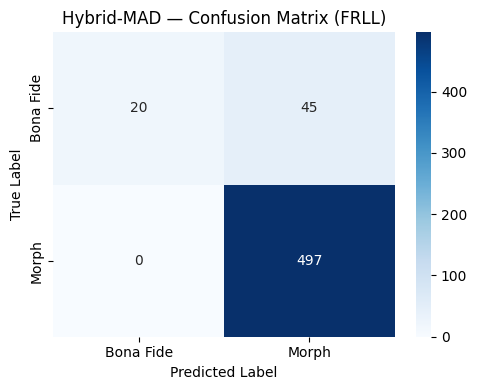

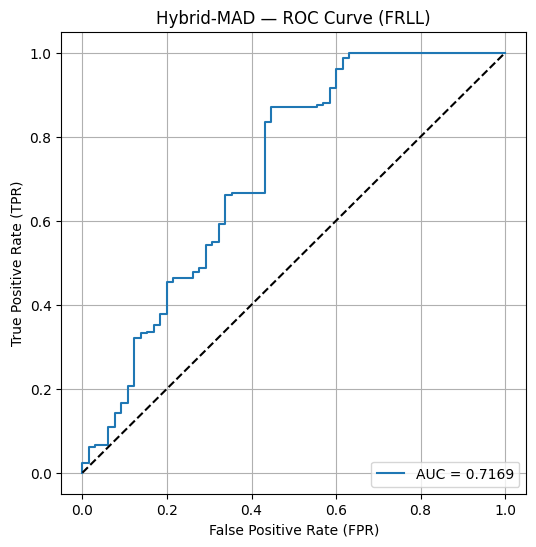

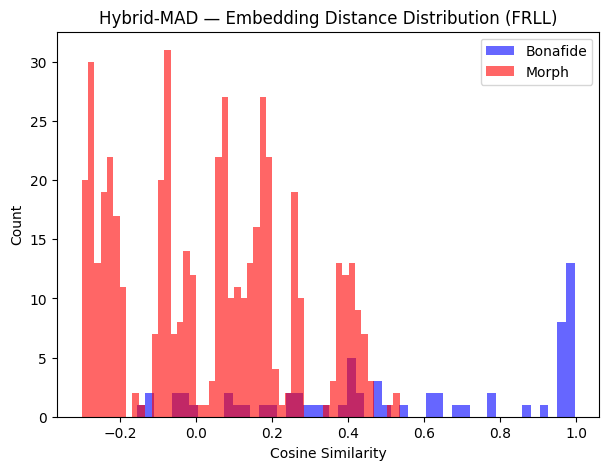

In [34]:
MODEL_NAME = "Hybrid-MAD"

evaluate_and_plot(
    embed_model=dmad_model,
    dataloader=frll_test_loader,
    device=device,
    model_name=MODEL_NAME,
    dataset_name = "FRLL"
)


===== TEST EVALUATION (FIXED THRESHOLD) =====
Threshold: 0.9729864932466232
Accuracy : 89.55%
Precision: 0.8912
Recall   : 1.0000
F1-score : 0.9425
ROC-AUC  : 0.9993
FAR      : 0.0000
FRR      : 0.7233
Avg Bona Cosine : 0.90663713
Avg Morph Cosine: 0.45415074


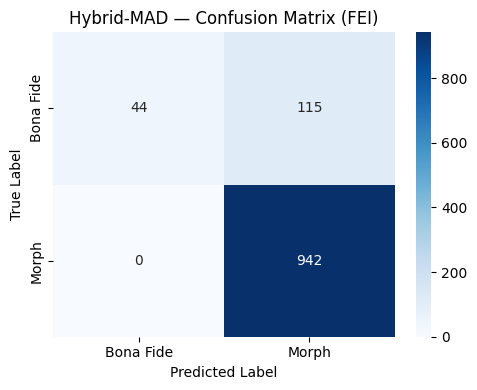

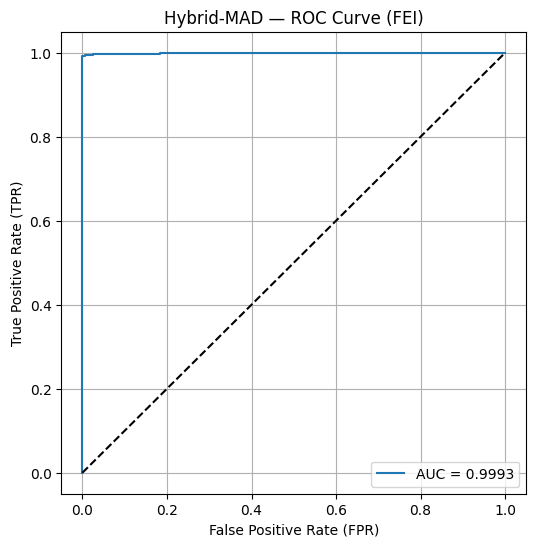

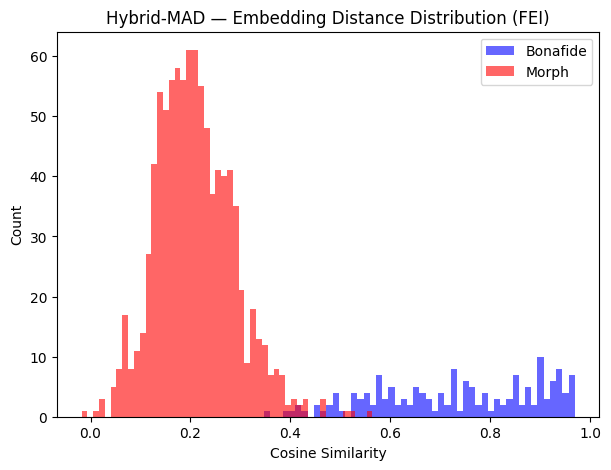

In [35]:
MODEL_NAME = "Hybrid-MAD"

evaluate_and_plot(
    embed_model=dmad_model,
    dataloader=dmad_test_loader,
    device=device,
    model_name=MODEL_NAME,
    dataset_name = "FEI"
)